# Data exploration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import energy_forecast
from energy_forecast.loaders import load_ods, load_ods_sheetnames
from energy_forecast.transform import clean_energy_data, clean_temp_data, clean_wind_data
from energy_forecast.transform import clean_sun_data, clean_rain_data
from energy_forecast.preprocessing import load_and_set_types
from energy_forecast.utils import repo_root
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.detrend import STLTransformer
from statsmodels.graphics.tsaplots import month_plot, plot_acf
from pathlib import Path

In [3]:
REPO_ROOT = Path(repo_root())
DATA_INTERIM = REPO_ROOT / 'data' / 'interim'
DATA_FILE_PATH = DATA_INTERIM / 'transformed_energy_weather.csv'
DATA_PROCESSED = REPO_ROOT / "data" / "processed"

In [4]:
weather_cols = {
    'temp': 'degC',
    'wind': 'knots',
    'sun': 'hours',
    'rain': 'mm',
}
energy_cols = {
    'total_energy': 'mtoe', 
    'coal': 'mtoe', 
    'petroleum': 'mtoe', 
    'natural gas': 'mtoe', 
    'bioenergy & waste': 'mtoe', 
    'elec_nuclear': 'mtoe', 
    'elec_renewable': 'mtoe', 
    'elec_import': 'mtoe', 
}
combined_cols = dict(**energy_cols, **weather_cols)

# Load only the train dataset

This is so we don't look at the test set and keep as "pure" as possible without overfitting our analysis to it by looking at the full dataset together.  Even EDA on the full dataset can lead us to draw conclusions and build biases into our model later

In [5]:
train = load_and_set_types(DATA_PROCESSED / 'train.csv')
print(f'{train.shape=}')

train.shape=(193, 12)


# Prepare dataset for analysis

In [6]:
TARGET_COL = 'total_energy'
EXPLANATORY_COLS = ['temp','wind','sun','rain']

def add_year_month(df: pd.DataFrame) -> pd.DataFrame:
    """Add year and month cols for seasonal plotting"""
    df = df.assign(
        year=lambda x: x.index.to_series().dt.year,
        month=lambda x: x.index.to_series().dt.month,
    )
    return df

def prepare_y(df: pd.DataFrame) -> pd.DataFrame:
    """Extract target variable and add features"""
    y_train = (
        df
        .loc[:, [TARGET_COL]]
        .pipe(add_year_month)
    )
    return y_train

def prepare_x(df: pd.DataFrame) -> pd.DataFrame:
    """Extract explanatory variables and add features"""
    x_train = (
        df
        .loc[:, EXPLANATORY_COLS]
        .pipe(add_year_month)
    )
    return x_train

x_train = prepare_x(train)
y_train = prepare_y(train)

print(f'{x_train.shape=}, cols={x_train.columns.tolist()}')
print(f'{y_train.shape=}, cols={y_train.columns.tolist()}')

x_train.shape=(193, 6), cols=['temp', 'wind', 'sun', 'rain', 'year', 'month']
y_train.shape=(193, 3), cols=['total_energy', 'year', 'month']


## Timeseries Plots

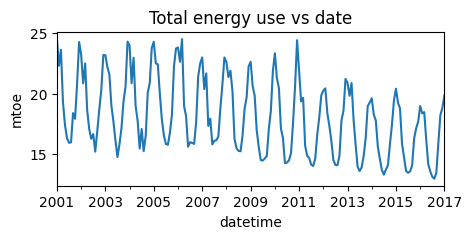

In [7]:
# Time plot for total energy use
fig, ax = plt.subplots(figsize=(5, 2))
y_train[TARGET_COL].plot(ax=ax)
ax.set_ylabel('mtoe');
ax.set_title('Total energy use vs date');

Focussing on just the total energy use **(which is the one we will mostly be analysing and trying to forecast)**
- Training set goes from 2001 to 2017.
- Trend is decreasing over time, not quite linearly.
- Looks like there is a strong yearly seasonality
- The amplitude of the seasonality component looks quite consistent.

## STL decomp

In [8]:
def get_stl_decomp(y: pd.DataFrame, col: str) -> pd.DataFrame:
    stl = STLTransformer(sp=12, return_components=True)
    decomposed = (
        y
        .loc[:, col]
        .pipe(stl.fit_transform)
        .merge(y, on='datetime')
    )
    return decomposed

decomposed = get_stl_decomp(y_train, col=TARGET_COL)
print(f'{decomposed.shape=}\ncols={decomposed.columns.tolist()}')

decomposed.shape=(193, 7)
cols=['transformed', 'seasonal', 'trend', 'resid', 'total_energy', 'year', 'month']


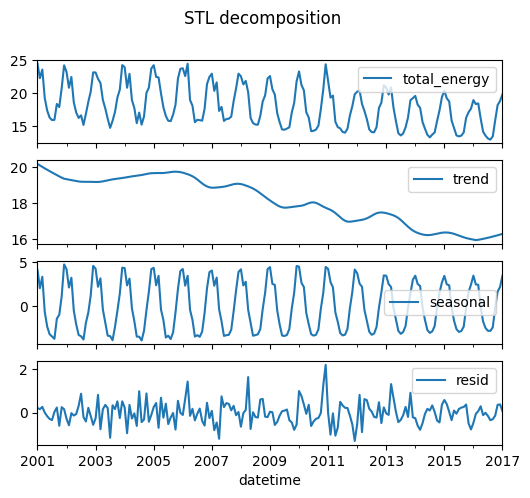

In [9]:
# Plot STL decomposition
fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(6,5))
cols = ['total_energy', 'trend', 'seasonal', 'resid']
for ax, col in zip(axs, cols): 
    decomposed.plot(y=col, ax=ax)
fig.suptitle('STL decomposition');

### Seasonal plot

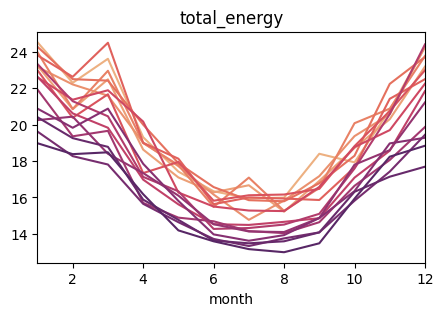

In [10]:
# Seasonal plot for energy consumption
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_xticks(list(range(0,13,2)))
sns.lineplot(data=y_train, x='month', y='total_energy', 
             hue='year', ax=ax, palette='flare',
             legend=None)
ax.set_ylabel('')
ax.set_xlim([1,12])
ax.set_title('total_energy');


This grid of plots shows each season's data overlaid on an annual period.  Gives a quick intuition of the seasonal trends in the data
- Quite a strong, similar seasonality effect.
- The seasonality in total energy use must be mostly due to the natural gas and coal seasonality.  These are probably driven by heating demand in winter months?

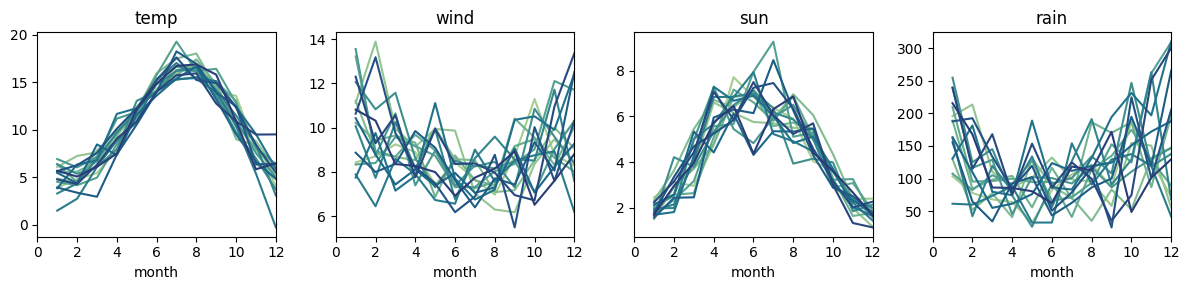

In [11]:
# Plot seasonal for weather
fig = plt.figure()
fig.set_size_inches(12,3)
for i, col in enumerate(['temp','wind','sun','rain']):
    sharex = ax if i>0 else None
    ax = fig.add_subplot(1,4,i+1, sharex=sharex)
    sns.lineplot(data=x_train, x='month', y=col, hue='year', ax=ax, palette='crest' , legend=None)
    ax.set_xlim([0,12])
    ax.set_xticks(list(range(0,13,2)))
    ax.set_ylabel('')
    ax.set_title(col)
fig.tight_layout()

# TODO - work on this vis

Likewise this plot grid shows the same thing, but for the weather data.
- Strong seasonality for Temps and daily Sunlight. Is inverse w.r.t. the total energy use seasonality we saw earlier.  Strong indication that UK energy use is driven by weather, and therefore heating demands.
- Wind speeds and rainfall have the opposite seasonality to Temp and daily Sunlight.
- These 4 charts basically confirm the expected seasonal weather patterns we see in this country.

### Seasonal subseries plot

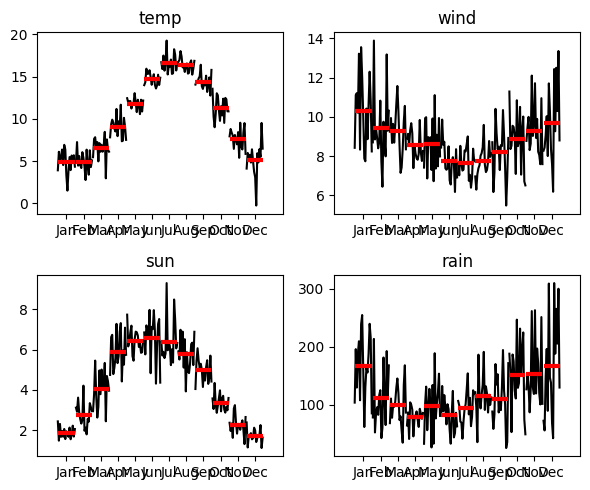

In [12]:
# Plot seasonal subseries plot for a few features
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 5))
axs = [ax for ax_row in axs for ax in ax_row]
cols = ['temp', 'wind', 'sun', 'rain']
for col, ax in zip(cols, axs):
    month_plot(train[col], ax=ax);
    ax.set_title(col)
    fig.tight_layout()

This seasonal subseries plot puts each month's data togather, so we can see the annual trend at each point in the year (seasonal period). by the shape of each line segment, rather than the colours on the previous seasonal grid plots.  

The mean value for each month is also plotted, so we can see the seasonal variation a bit more clearly.
- All columns shown have quite clear seasonality
- Total energy is highly seasonal (just like gas and coal use), but the decreasing trend is quite sharp in recent years and is quite consistent across all months.  We could conclude that the decreasing trend is more driven by decreases in other less seasonal energy sources like petroleum etc.
- We can see a strong rise in renewable energy use, though still small in proportion to other sources.

### Scatter matrix

In [14]:
weather_cols

{'temp': 'degC', 'wind': 'knots', 'sun': 'hours', 'rain': 'mm'}

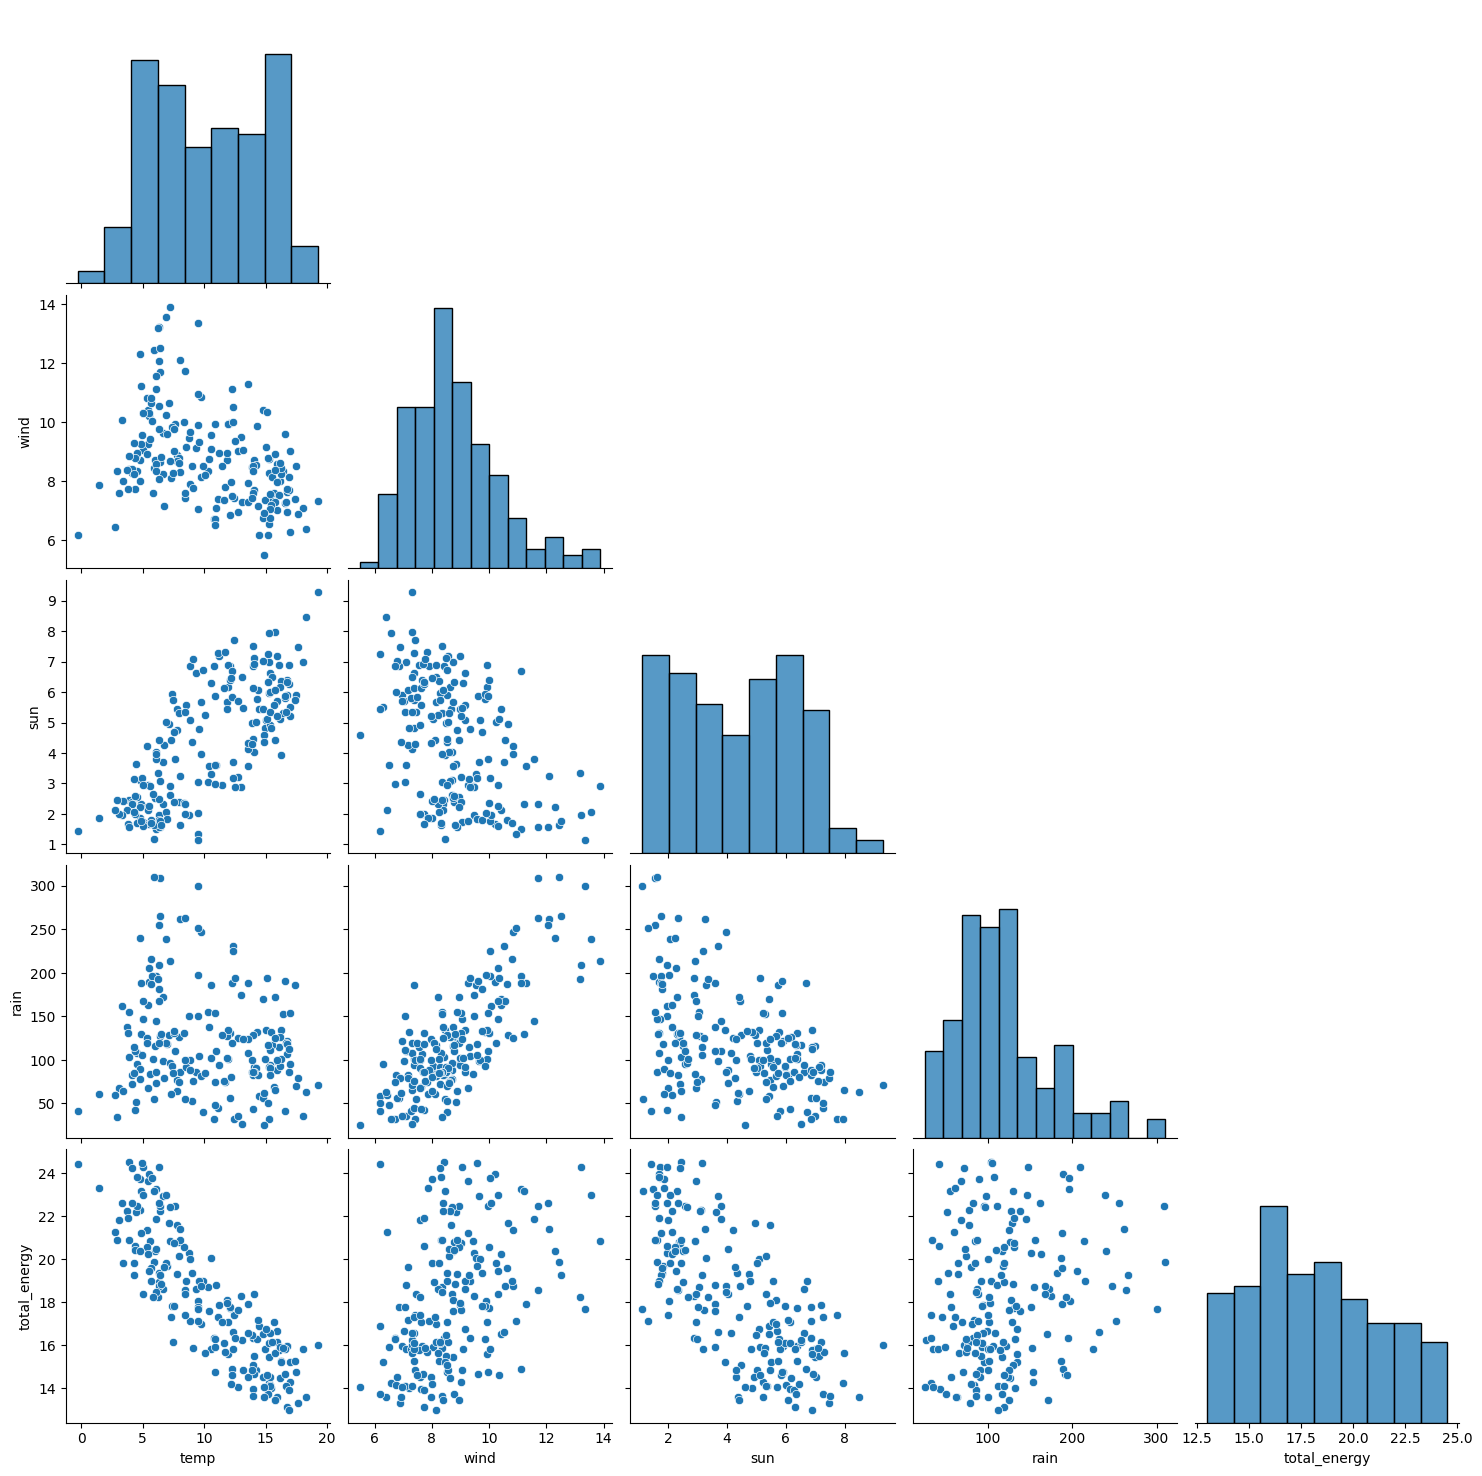

In [30]:
# Scatter matrix
xy_combined = pd.concat([x_train, y_train], axis=1).drop(columns=['year', 'month'])

sns.pairplot(combined, corner=True, height=3);

### Lag plot (TODO)

In [26]:
# TODO
# MAYBE leave it if the ACF plot shows enough info

### Autocorrelation plot

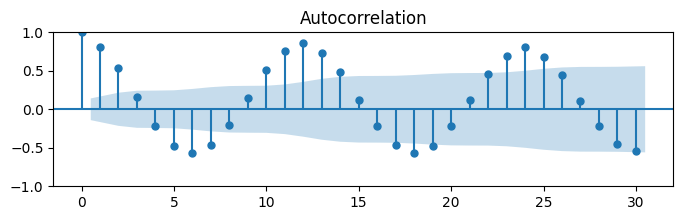

In [29]:
# ACF plot
fig, ax = plt.subplots(figsize=(8,2))
plot_acf(y_train['total_energy'], ax=ax, lags=30);

- Trough at 6 months, and peak at 12 months.  This is (unsurprisingly) showing us the 12-month seasonal period in the data.
- Strong correlation at seasonal lags, correlation coefficient close to 1 at every 12 month lag.  This suggests we could do quite well forecasting with just a simple **seasonal naive method**

### Correlation matrix (pearson)
We'll try this to establish correlation coefs for all available predictors.  Including weather fields

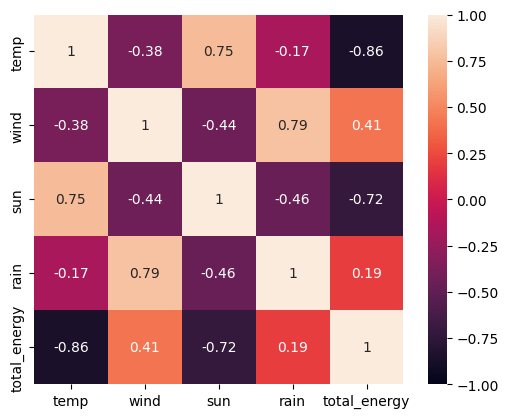

In [31]:
import seaborn as sns
corr = xy_combined.corr()
sns.heatmap(corr, square=True, annot=True, vmin=-1, vmax=1);

- Strong correlation with temperature and sunlight
- both temperature and sunlight are quote strongly correlated, could be multicollinearity problem?

# Conclusions
Here are some high level conclusions we can draw from this quick analysis:
- Strng annual seasonality
- Excellent candidate for seasonal naive forecaster
- ...
